@ Classification using Decision Tree and Random Forest

In [1]:
# General library
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import json
# For encoder
from sklearn.preprocessing import LabelEncoder
# Check value 
from pandas.api.types import is_numeric_dtype

# Library for Decision Tree
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
# Library for time series LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
## For normalize the data
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# Metric for evaluation the model
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

#To save the model
import pickle

# Load Dataframe from data directory

In [2]:
data_path = "./data/"
data = pd.DataFrame()
for file in os.listdir(data_path):
    # Reading from json file
    json_object = pd.read_json(data_path + file)
    # We only need data in "hour"
    json_object = json_object['forecast']['forecastday'].pop(0)
    json_object = json_object["hour"]
    temp_df = pd.json_normalize(json_object)
    data = pd.concat([data,temp_df])
data

,chance_of_rain,chance_of_snow,cloud,dewpoint_c,dewpoint_f,feelslike_c,feelslike_f,gust_kph,gust_mph,heatindex_c,...,will_it_snow,wind_degree,wind_dir,wind_kph,wind_mph,windchill_c,windchill_f,condition.code,condition.icon,condition.text
0,0,0,25,21.4,70.5,27.6,81.6,12.1,7.5,27.6,...,0,141,SE,7.6,4.7,25.4,77.7,1000,//cdn.weatherapi.com/weather/64x64/night/113.png,Clear
1,0,0,24,21.6,70.8,27.3,81.1,9.9,6.2,27.3,...,0,136,SE,6.1,3.8,25.1,77.2,1000,//cdn.weatherapi.com/weather/64x64/night/113.png,Clear
2,0,0,21,21.6,70.8,27.0,80.5,5.3,3.3,27.0,...,0,138,SE,3.2,2.0,24.8,76.7,1000,//cdn.weatherapi.com/weather/64x64/night/113.png,Clear
3,0,0,22,21.5,70.7,26.7,80.1,3.0,1.9,26.7,...,0,351,N,1.8,1.1,24.6,76.2,1000,//cdn.weatherapi.com/weather/64x64/night/113.png,Clear
4,0,0,21,21.4,70.4,26.6,79.8,10.1,6.3,26.6,...,0,348,NNW,6.1,3.8,24.5,76.1,1000,//cdn.weatherapi.com/weather/64x64/night/113.png,Clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,0,0,55,23.1,73.6,26.6,79.9,8.4,5.2,26.6,...,0,336,NNW,5.0,3.1,24.0,75.3,1030,//cdn.weatherapi.com/weather/64x64/night/143.png,Mist
20,45,0,82,23.0,73.4,26.5,79.7,4.3,2.7,26.5,...,0,288,WNW,2.5,1.6,24.0,75.1,1030,//cdn.weatherapi.com/weather/64x64/night/143.png,Mist
21,45,0,57,23.0,73.4,26.6,79.8,5.5,3.4,26.6,...,0,271,W,3.2,2.0,24.0,75.2,1030,//cdn.weatherapi.com/weather/64x64/night/143.png,Mist
22,100,0,65,23.0,73.3,26.6,79.9,0.6,0.4,26.6,...,0,288,WNW,0.4,0.2,24.1,75.3,1150,//cdn.weatherapi.com/weather/64x64/night/263.png,Patchy light drizzle


In [3]:
# Choose only columns in list
# Train data
df = data[["temp_c","temp_f","is_day","wind_mph","wind_kph","wind_degree","wind_dir","pressure_mb","pressure_in","precip_mm","precip_in","humidity","cloud","feelslike_c","feelslike_f","windchill_c","windchill_f","heatindex_c","heatindex_f","dewpoint_c","dewpoint_f","vis_km","vis_miles","uv","gust_mph","gust_kph"]]
# Test data
label = data["condition.code"]
df

,temp_c,temp_f,is_day,wind_mph,wind_kph,wind_degree,wind_dir,pressure_mb,pressure_in,precip_mm,...,windchill_f,heatindex_c,heatindex_f,dewpoint_c,dewpoint_f,vis_km,vis_miles,uv,gust_mph,gust_kph
0,25.4,77.7,0,4.7,7.6,141,SE,1011.0,29.85,0.00,...,77.7,27.6,81.6,21.4,70.5,10.0,6.0,0.0,7.5,12.1
1,25.1,77.2,0,3.8,6.1,136,SE,1010.0,29.84,0.00,...,77.2,27.3,81.1,21.6,70.8,10.0,6.0,0.0,6.2,9.9
2,24.8,76.6,0,2.0,3.2,138,SE,1010.0,29.82,0.00,...,76.7,27.0,80.5,21.6,70.8,10.0,6.0,0.0,3.3,5.3
3,24.6,76.2,0,1.1,1.8,351,N,1010.0,29.82,0.00,...,76.2,26.7,80.1,21.5,70.7,10.0,6.0,0.0,1.9,3.0
4,24.5,76.1,0,3.8,6.1,348,NNW,1010.0,29.82,0.00,...,76.1,26.6,79.8,21.4,70.4,10.0,6.0,0.0,6.3,10.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,24.0,75.3,0,3.1,5.0,336,NNW,1009.0,29.78,0.00,...,75.3,26.6,79.9,23.1,73.6,2.0,1.0,0.0,5.2,8.4
20,24.0,75.1,0,1.6,2.5,288,WNW,1010.0,29.82,0.02,...,75.1,26.5,79.7,23.0,73.4,2.0,1.0,0.0,2.7,4.3
21,24.0,75.2,0,2.0,3.2,271,W,1010.0,29.83,0.00,...,75.2,26.6,79.8,23.0,73.4,2.0,1.0,0.0,3.4,5.5
22,24.1,75.3,0,0.2,0.4,288,WNW,1010.0,29.82,0.25,...,75.3,26.6,79.9,23.0,73.3,5.0,3.0,0.0,0.4,0.6


# Label encoder for Decision Tree

In [4]:
le = LabelEncoder()

In [5]:
for column in df.columns:
    # Only encoder categorical or numerical
    if not is_numeric_dtype(df[column]):
        df[column] = le.fit_transform(df[column])
# Double check if all values if numeric
for column in df.columns:
    if not is_numeric_dtype(df[column]):
        print("There still object type values")

df

C:\Users\Administrator\AppData\Local\Temp\ipykernel_24332\2049315630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column])


,temp_c,temp_f,is_day,wind_mph,wind_kph,wind_degree,wind_dir,pressure_mb,pressure_in,precip_mm,...,windchill_f,heatindex_c,heatindex_f,dewpoint_c,dewpoint_f,vis_km,vis_miles,uv,gust_mph,gust_kph
0,25.4,77.7,0,4.7,7.6,141,9,1011.0,29.85,0.00,...,77.7,27.6,81.6,21.4,70.5,10.0,6.0,0.0,7.5,12.1
1,25.1,77.2,0,3.8,6.1,136,9,1010.0,29.84,0.00,...,77.2,27.3,81.1,21.6,70.8,10.0,6.0,0.0,6.2,9.9
2,24.8,76.6,0,2.0,3.2,138,9,1010.0,29.82,0.00,...,76.7,27.0,80.5,21.6,70.8,10.0,6.0,0.0,3.3,5.3
3,24.6,76.2,0,1.1,1.8,351,3,1010.0,29.82,0.00,...,76.2,26.7,80.1,21.5,70.7,10.0,6.0,0.0,1.9,3.0
4,24.5,76.1,0,3.8,6.1,348,6,1010.0,29.82,0.00,...,76.1,26.6,79.8,21.4,70.4,10.0,6.0,0.0,6.3,10.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,24.0,75.3,0,3.1,5.0,336,6,1009.0,29.78,0.00,...,75.3,26.6,79.9,23.1,73.6,2.0,1.0,0.0,5.2,8.4
20,24.0,75.1,0,1.6,2.5,288,14,1010.0,29.82,0.02,...,75.1,26.5,79.7,23.0,73.4,2.0,1.0,0.0,2.7,4.3
21,24.0,75.2,0,2.0,3.2,271,13,1010.0,29.83,0.00,...,75.2,26.6,79.8,23.0,73.4,2.0,1.0,0.0,3.4,5.5
22,24.1,75.3,0,0.2,0.4,288,14,1010.0,29.82,0.25,...,75.3,26.6,79.9,23.0,73.3,5.0,3.0,0.0,0.4,0.6


In [6]:
X_train, X_test, y_train, y_test = train_test_split(df, label, random_state=21522592)

In [7]:
clf = DecisionTreeClassifier(random_state=21522592)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=21522592)

# Plotting tree and evaluate the Decision Tree model

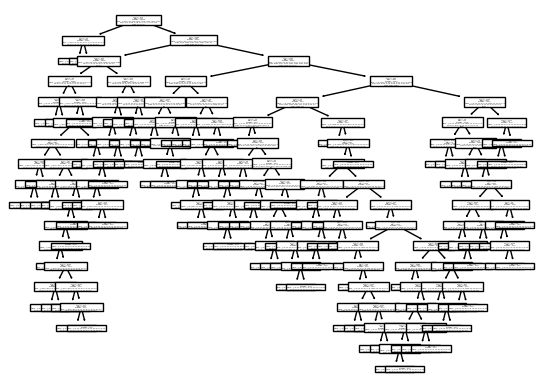

In [8]:
tree.plot_tree(clf, proportion=True)
plt.savefig('out.pdf')
plt.show()

In [9]:
# Predict the label with X_test
lable_pred = clf.predict(X_test)

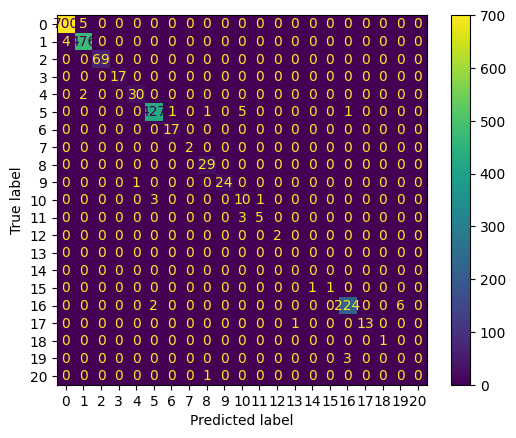

In [10]:
cm = confusion_matrix(y_test, lable_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [11]:
# Prin precision score
print(f"Micro precision score : " + str(precision_score(y_test, lable_pred, average='micro')))
print(f"Macro precision score : " + str(precision_score(y_test, lable_pred, average='macro')))
print(f"Weighted precision score : " + str(precision_score(y_test, lable_pred, average='weighted')))
print(f"None avrerage precision score : " + str(precision_score(y_test, lable_pred, average=None)))
print(f"None avrerage precision score with zero divsion set to 1 : " + str(precision_score(y_test, lable_pred, average=None, zero_division=1)))
print(f"None avrerage precision score with zero divsion set to nan: " + str(precision_score(y_test, lable_pred, average=None, zero_division=np.nan)))

Micro precision score : 0.9803639846743295
Macro precision score : 0.7708222206788926
Weighted precision score : 0.983012295486311
None avrerage precision score : [0.99431818 0.98550725 1.         1.         0.96774194 0.98842593
 0.94444444 1.         0.93548387 1.         0.55555556 0.83333333
 1.         0.         0.         1.         0.98245614 1.
 1.         0.         0.        ]
None avrerage precision score with zero divsion set to 1 : [0.99431818 0.98550725 1.         1.         0.96774194 0.98842593
 0.94444444 1.         0.93548387 1.         0.55555556 0.83333333
 1.         0.         0.         1.         0.98245614 1.
 1.         0.         1.        ]
None avrerage precision score with zero divsion set to nan: [0.99431818 0.98550725 1.         1.         0.96774194 0.98842593
 0.94444444 1.         0.93548387 1.         0.55555556 0.83333333
 1.         0.         0.         1.         0.98245614 1.
 1.         0.                nan]


c:\Users\Administrator\Downloads\Weather_Prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\Downloads\Weather_Prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\Downloads\Weather_Prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [12]:
# Prin recall score
print(f"Micro recall score : " + str(recall_score(y_test, lable_pred, average='micro')))
print(f"Macro recall score : " + str(recall_score(y_test, lable_pred, average='macro')))
print(f"Weighted recall score : " + str(recall_score(y_test, lable_pred, average='weighted')))
print(f"None avrerage recall score : " + str(recall_score(y_test, lable_pred, average=None)))
print(f"None avrerage recall score with zero divsion set to 1 : " + str(recall_score(y_test, lable_pred, average=None, zero_division=1)))
print(f"None avrerage recall score with zero divsion set to nan: " + str(recall_score(y_test, lable_pred, average=None, zero_division=np.nan)))

Micro recall score : 0.9803639846743295
Macro recall score : 0.7427170498916124
Weighted recall score : 0.9803639846743295
None avrerage recall score : [0.9929078  0.99166667 1.         1.         0.9375     0.9816092
 1.         1.         1.         0.96       0.71428571 0.625
 1.         0.         0.         0.5        0.96551724 0.92857143
 1.         0.         0.        ]
None avrerage recall score with zero divsion set to 1 : [0.9929078  0.99166667 1.         1.         0.9375     0.9816092
 1.         1.         1.         0.96       0.71428571 0.625
 1.         1.         1.         0.5        0.96551724 0.92857143
 1.         0.         0.        ]
None avrerage recall score with zero divsion set to nan: [0.9929078  0.99166667 1.         1.         0.9375     0.9816092
 1.         1.         1.         0.96       0.71428571 0.625
 1.                nan        nan 0.5        0.96551724 0.92857143
 1.         0.         0.        ]


c:\Users\Administrator\Downloads\Weather_Prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\Downloads\Weather_Prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\Downloads\Weather_Prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [13]:
# Prin f1_score
print(f"Micro f1_score : " + str(f1_score(y_test, lable_pred, average='micro')))
print(f"Macro f1_score : " + str(f1_score(y_test, lable_pred, average='macro')))
print(f"Weighted f1_score : " + str(f1_score(y_test, lable_pred, average='weighted')))
print(f"None avrerage f1_score : " + str(f1_score(y_test, lable_pred, average=None)))

Micro f1_score : 0.9803639846743295
Macro f1_score : 0.7514329540549893
Weighted f1_score : 0.9814329410491874
None avrerage f1_score : [0.99361249 0.98857736 1.         1.         0.95238095 0.98500577
 0.97142857 1.         0.96666667 0.97959184 0.625      0.71428571
 1.         0.         0.         0.66666667 0.97391304 0.96296296
 1.         0.         0.        ]


In [14]:
# Save the model and label encoder
with open('decision_tree.pkl','wb') as f:
    pickle.dump(clf,f)
np.save('classes.npy', le.classes_)

# Predict future values using LSTM on temperature and condition code

In [18]:
# dataset = data["condition.code"]
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data[["temp_c","condition.code"]])

In [19]:

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5595 2757


In [20]:

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [21]:

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [22]:

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [23]:

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

c:\Users\Administrator\Downloads\Weather_Prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
5593/5593 - 4s - 644us/step - loss: 0.0100
Epoch 2/100
5593/5593 - 3s - 561us/step - loss: 0.0032
Epoch 3/100
5593/5593 - 3s - 573us/step - loss: 0.0031
Epoch 4/100
5593/5593 - 3s - 556us/step - loss: 0.0032
Epoch 5/100
5593/5593 - 3s - 548us/step - loss: 0.0032
Epoch 6/100
5593/5593 - 3s - 553us/step - loss: 0.0032
Epoch 7/100
5593/5593 - 3s - 531us/step - loss: 0.0032
Epoch 8/100
5593/5593 - 3s - 519us/step - loss: 0.0031
Epoch 9/100
5593/5593 - 3s - 508us/step - loss: 0.0031
Epoch 10/100
5593/5593 - 3s - 499us/step - loss: 0.0032
Epoch 11/100
5593/5593 - 3s - 499us/step - loss: 0.0032
Epoch 12/100
5593/5593 - 3s - 496us/step - loss: 0.0031
Epoch 13/100
5593/5593 - 3s - 498us/step - loss: 0.0032
Epoch 14/100
5593/5593 - 3s - 516us/step - loss: 0.0031
Epoch 15/100
5593/5593 - 3s - 522us/step - loss: 0.0031
Epoch 16/100
5593/5593 - 3s - 522us/step - loss: 0.0032
Epoch 17/100
5593/5593 - 3s - 537us/step - loss: 0.0032
Epoch 18/100
5593/5593 - 3s - 541us/step - loss: 0.0031
E

In [24]:

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step


ValueError: non-broadcastable output operand with shape (5593,1) doesn't match the broadcast shape (5593,2)

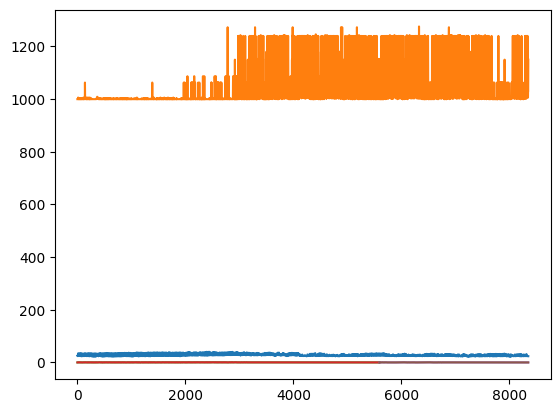

In [25]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [26]:
# Save the model
# save
with open('LSTM.pkl','wb') as f:
    pickle.dump(model,f)